In [14]:
import json
import pandas as pd
import numpy as np
import numexpr as ne
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
import wandb
from dotenv import load_dotenv
from tqdm import tqdm
import torch
import torch.cuda.amp as amp

from src.model.model import save_model, load_inference_model
from src.dataset.df import df_dataset, check_dataset
from src.utils.common import set_seed

from src.experiment.inference import inference
from src.experiment.initialize import init_dataset, init_model, init_exp
from src.utils.metrics import compute_surface_dice_score_from_volume

In [15]:
class cfg:
    debug = False
    check_dataset = True

    # = data CFG ====================================================

    dataset_path = "/kaggle/working/dataset/train01_xy_256_128_z_1_2/"
    train_dataset = "GaussLabelDataset"
    negative_sample_rate = 0.1
    max_distance = 20
    sigma1 = 0.4
    sigma2 = 0.001
    weight = 0.5
    # = experiment CFG =================================================

    project = "SenNet"
    exp_name = os.path.basename(os.getcwd())
    notes = "GaussLabelDataset preliminaly"

    # = model CFG ======================================================

    model_arch = "Unet"
    backbone = "se_resnext50_32x4d"
    in_chans = 1
    target_size = 1

    # = training CFG ===================================================

    epochs = 20

    train_batch_size = 64
    valid_batch_size = train_batch_size

    loss = "DiceLoss"
    metrics = "Dice"
    lr = 5e-4
    num_workers = 12

    # = augmentation ===================================================

    image_size = 256
    train_aug = [
        A.RandomRotate90(p=0.5),
        A.RandomGamma(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.RandomResizedCrop(image_size, image_size, scale=(0.8, 1)),
        A.ShiftScaleRotate(p=0.5),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug = [
        ToTensorV2(transpose_mask=True),
    ]

    # =============== inference ========================================

    test_dataset = "BaseInferenceDataset"
    stride = image_size // 2
    drop_egde_pixel = 32


load_dotenv("/kaggle/key.env")
set_seed()

/tmp/ipykernel_2243/4046888049.py:10: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{cfg.dataset_path}/dataset.csv")


image_path  \
0       /kaggle/working/dataset/cropped_xy_256_128_z_1...   
1       /kaggle/working/dataset/cropped_xy_256_128_z_1...   
2       /kaggle/working/dataset/cropped_xy_256_128_z_1...   
3       /kaggle/working/dataset/cropped_xy_256_128_z_1...   
4       /kaggle/working/dataset/cropped_xy_256_128_z_1...   
...                                                   ...   
452169  /kaggle/working/dataset/cropped_xy_256_128_z_1...   
452170  /kaggle/working/dataset/cropped_xy_256_128_z_1...   
452171  /kaggle/working/dataset/cropped_xy_256_128_z_1...   
452172  /kaggle/working/dataset/cropped_xy_256_128_z_1...   
452173  /kaggle/working/dataset/cropped_xy_256_128_z_1...   

                                               label_path  \
0       /kaggle/working/dataset/cropped_xy_256_128_z_1...   
1       /kaggle/working/dataset/cropped_xy_256_128_z_1...   
2       /kaggle/working/dataset/cropped_xy_256_128_z_1...   
3       /kaggle/working/dataset/cropped_xy_256_128_z_1...   
4       /kaggle/working/dataset/cropped_xy_256_128_z_1...   
...                                                   ...   
452169  /kaggle/working/dataset/cropped_xy_256_128_z_1...   
452170  /kaggle/working/dataset/cropped_xy_256_128_z_1...   
452171  /kaggle/working/dataset/cropped_xy_256_128_z_1...   
452172  /kaggle/working/dataset/cropped_xy_256_128_z_1...   
452173  /kaggle/working/dataset/cropped_xy_256_128_z_1...   

                                 fname           kidney    x    y    z  std  \
0                x0_y0_z0_std0039_sum0   kidney_1_dense    0    0    0   39   
1              x0_y0_z100_std0037_sum0   kidney_1_dense    0    0  100   37   
2              x0_y0_z102_std0036_sum0   kidney_1_dense    0    0  102   36   
3              x0_y0_z104_std0036_sum0   kidney_1_dense    0    0  104   36   
4              x0_y0_z106_std0036_sum0   kidney_1_dense    0    0  106   36   
...                                ...              ...  ...  ...  ...  ...   
452169  x896_y256_z990_std0261_sum1352  kidney_3_sparse  896  256  990  261   
452170  x896_y256_z992_std0262_sum1473  kidney_3_sparse  896  256  992  262   
452171  x896_y256_z994_std0263_sum1554  kidney_3_sparse  896  256  994  263   
452172  x896_y256_z996_std0264_sum1656  kidney_3_sparse  896  256  996  264   
452173  x896_y256_z998_std0265_sum1830  kidney_3_sparse  896  256  998  265   

         sum  fold0  fold1  
0          0  valid  train  
1          0  valid  train  
2          0  valid  train  
3          0  valid  train  
4          0  valid  train  
...      ...    ...    ...  
452169  1352  train    NaN  
452170  1473  train    NaN  
452171  1554  train    NaN  
452172  1656  train    NaN  
452173  1830  train    NaN  

[452174 rows x 11 columns]

train_len         : 217096
train_image_shape : torch.Size([1, 256, 256])
train_label_shape : torch.Size([1, 256, 256])
train_image_dtype : torch.float32
train_label_dtype : torch.float64

valid_len         : 235078
valid_image_shape : torch.Size([1, 256, 256])
valid_label_shape : torch.Size([1, 256, 256])
valid_image_dtype : torch.float32
valid_label_dtype : torch.float64


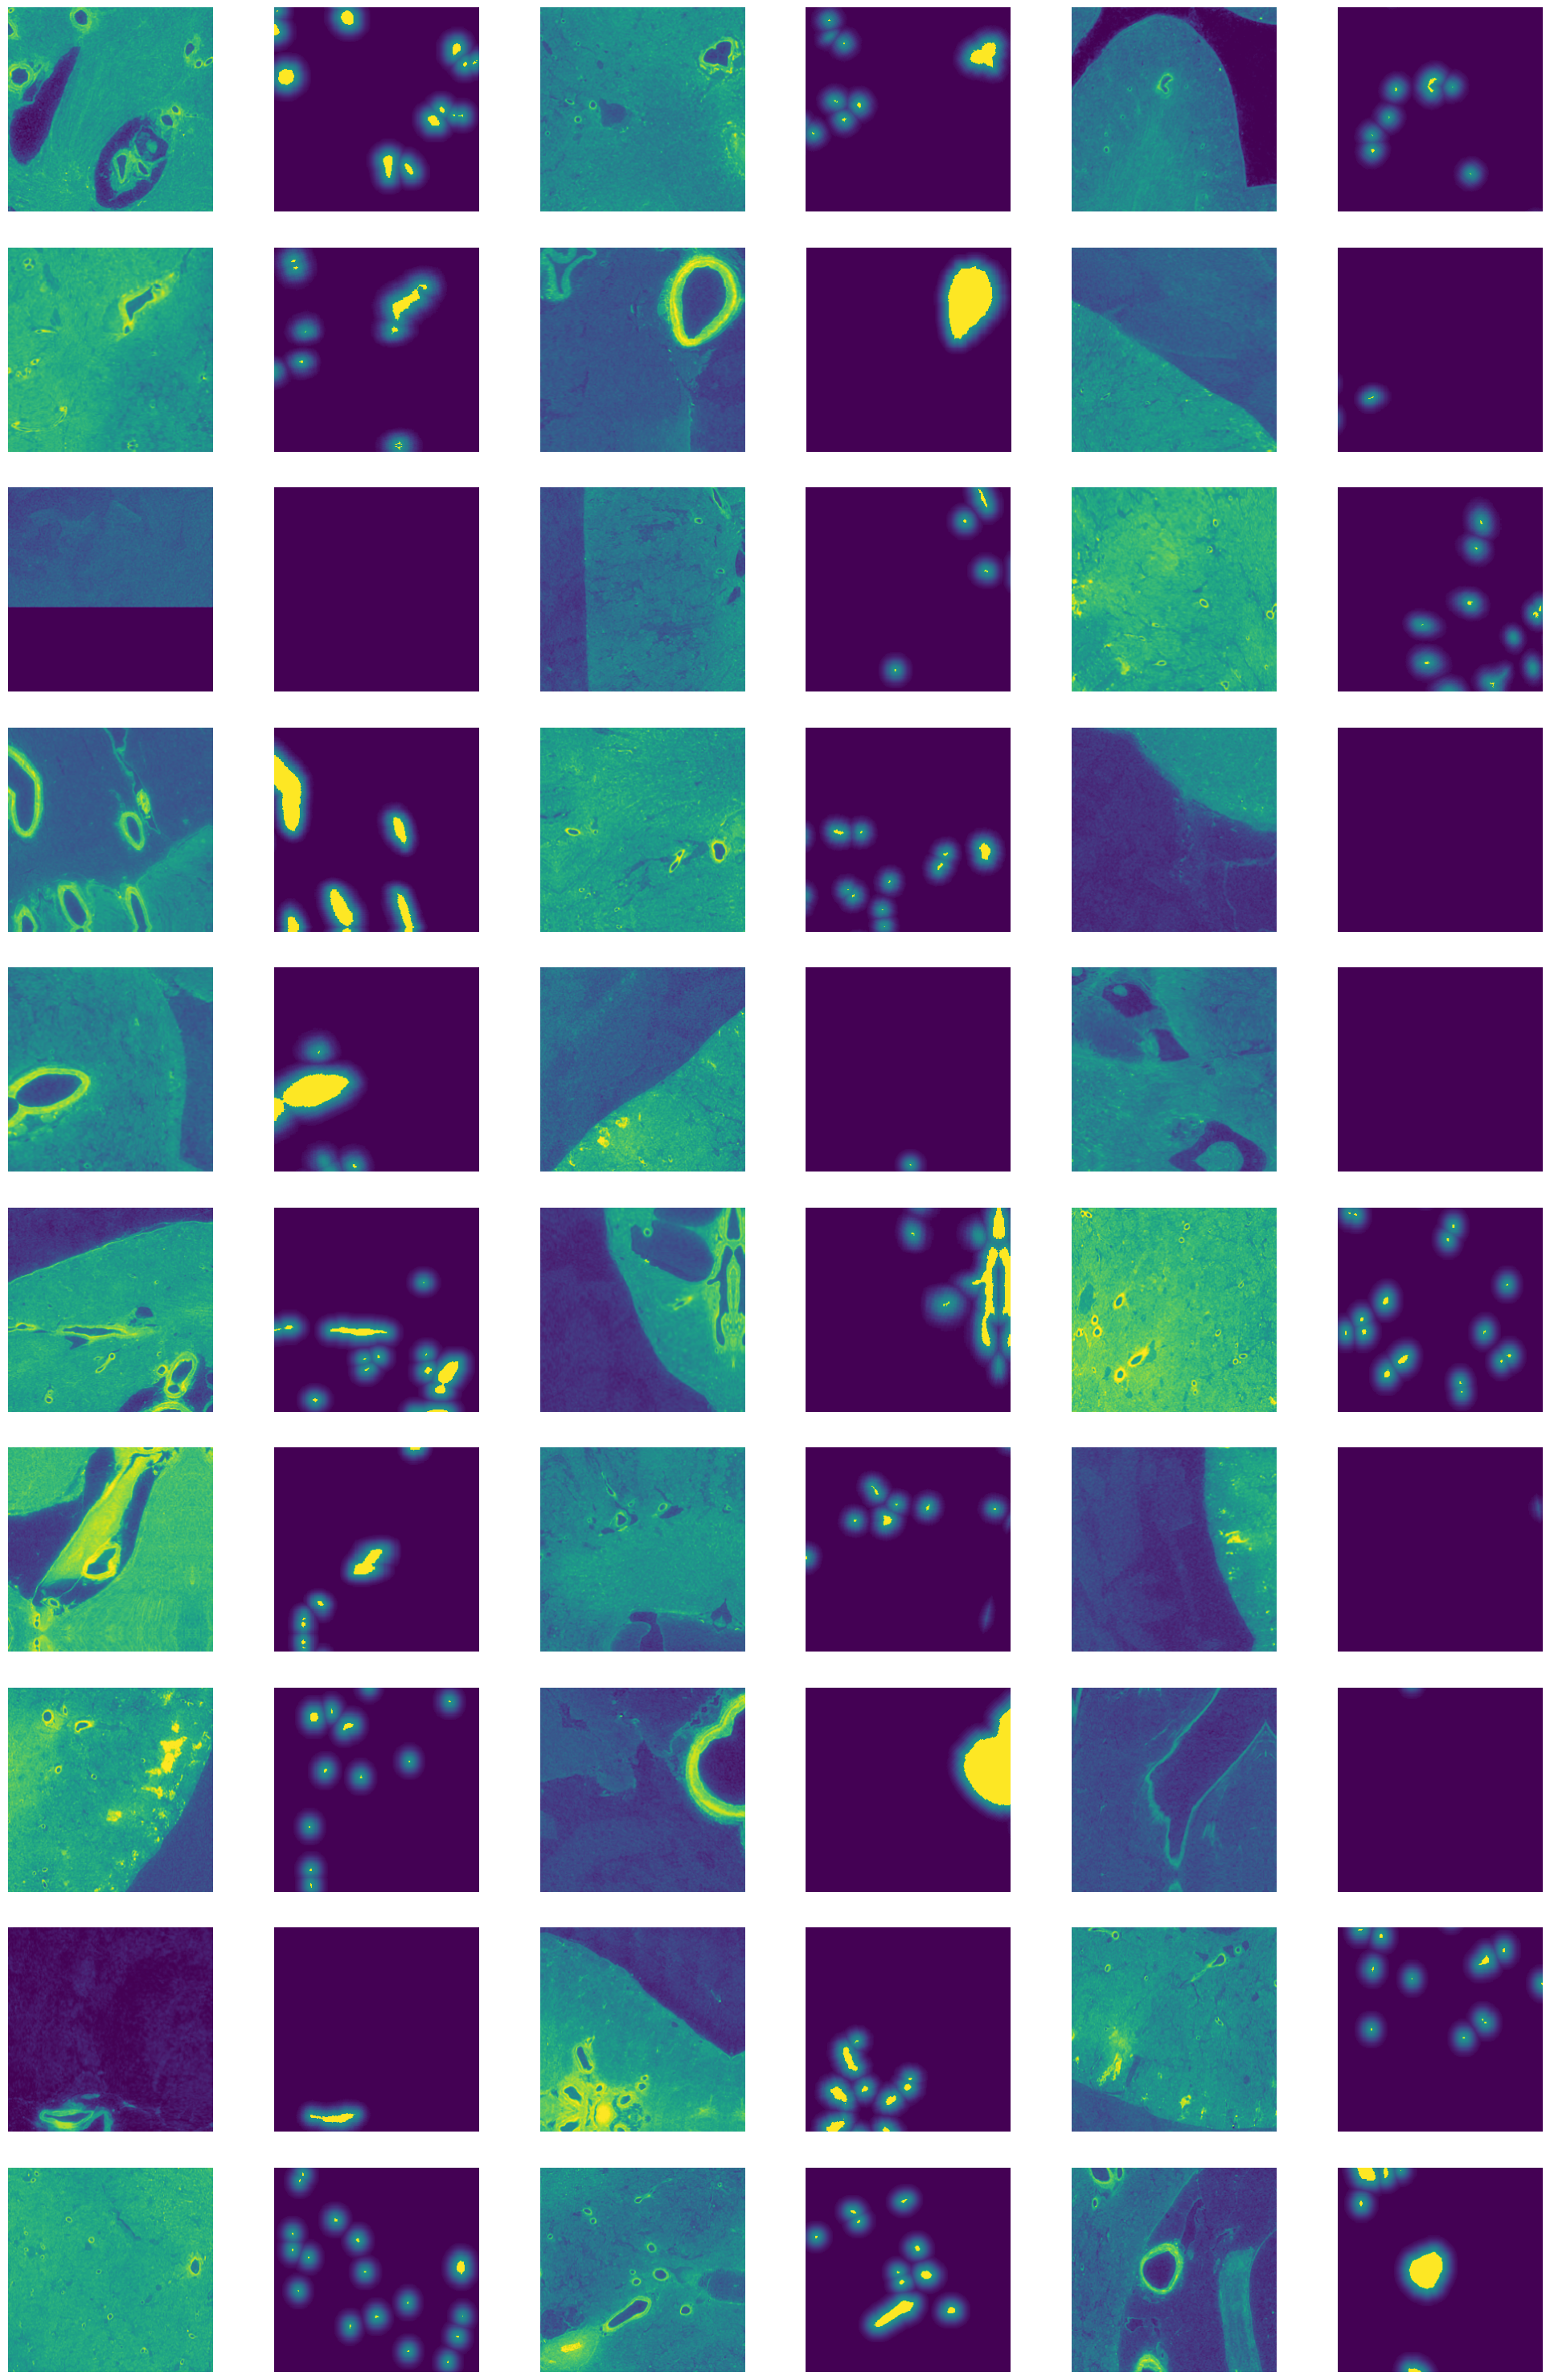

In [16]:
def filter_dataset(df):
    # trainのうちlabelが全くないものは90%の確率で除外
    df["random"] = np.random.rand(len(df))
    df = df[(df["sum"] > 0) | (df["fold0"] == "valid") | (df["random"] < cfg.negative_sample_rate)]
    df = df.reset_index(drop=True)
    df = df.drop(["random"], axis=1)
    return df


df = pd.read_csv(f"{cfg.dataset_path}/dataset.csv")
df = filter_dataset(df)
# df = df.sample(1000).reset_index(drop=True)
if cfg.debug:
    df = df.sample(10000).reset_index(drop=True)
display(df)

if cfg.check_dataset:
    check_dataset(df, cfg)

In [4]:
if cfg.debug:
    print("!!!Debug mode!!!\n")
    cfg.epochs = 5

for fold in range(2):
    train_dataloader, valid_dataloader = init_dataset(fold, df, cfg)
    model, scaler, criterion, optimizer, scheduler, metrics = init_model(cfg)
    slacknotify = init_exp(fold, cfg)

    path_best = f"./{cfg.exp_name}/{cfg.exp_name}_best_fold{fold}.pth"
    path_last = f"./{cfg.exp_name}/{cfg.exp_name}_last_fold{fold}.pth"

    best_loss = float("inf")
    for epoch in range(cfg.epochs):
        model.train()
        total_loss = 0.0
        pbar_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader), bar_format="{l_bar}{bar:10}{r_bar}{bar:-0b}")

        for i, (images, masks) in pbar_train:
            images, masks = images.cuda(), masks.cuda()
            optimizer.zero_grad()

            with amp.autocast():
                preds = model(images)
                loss = criterion(preds, masks)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                total_loss += loss.detach().item()

            loss_ = total_loss / (i + 1)
            lr = f"LR : {scheduler.get_lr()[0]:.2E}"
            gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
            pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{cfg.epochs}", gpu_mem, lr, f"Loss: {loss_:.4f}"))

        train_loss = loss_
        scheduler.step()
        wandb.log({"epoch": epoch, "train_loss": train_loss})

        model.eval()
        total_loss = 0.0
        pbar_val = tqdm(enumerate(valid_dataloader), total=len(valid_dataloader), bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")

        for i, (images, masks) in pbar_val:
            images, masks = images.cuda(), masks.cuda()
            with torch.no_grad():
                preds = model(images)
                loss = criterion(preds, masks)
                total_loss += loss.item()

            loss_ = total_loss / (i + 1)
            pbar_val.set_description(("%10s") % (f"Val Loss: {loss_:.4f}"))
        valid_loss = loss_
        wandb.log({"epoch": epoch, "valid_loss": valid_loss})

        if valid_loss < best_loss:
            print(f"loss : {valid_loss:.4f}\tSAVED MODEL\n")
            slacknotify.send_reply(f"epoch : {epoch}\tscore : {valid_loss:.4f}\tBEST")
            best_loss = valid_loss
            save_model(model, cfg, path_best, loss=loss)
        else:
            print(f"loss : {valid_loss:.4f}\n")
            slacknotify.send_reply(f"epoch : {epoch}\tscore : {valid_loss:.4f}")

    save_model(model, cfg, path_last, loss=valid_loss)
    wandb.config.update({"last_loss": valid_loss, "best_loss": best_loss})

    slacknotify.send_reply(f"{cfg.exp_name}_fold{fold} training finished\nbest loss : {best_loss:.4f} last loss : {loss_:.4f}", True)

    if wandb.run:
        wandb.finish()

model_arch:  Unet
backbone:  se_resnext50_32x4d


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: welshonionman. Use `wandb login --relogin` to force relogin


Epoch 0/20  Mem : 9.25GB  LR : 5.00E-04  Loss: 0.4424: 100%|██████████| 3393/3393 [10:19<00:00,  5.48it/s]
Val Loss: 0.4888: 100%|██████████| 3674/3674 [08:39<00:00,  7.07it/s]


loss : 0.4888	SAVED MODEL



Epoch 1/20  Mem : 11.1GB  LR : 5.00E-03  Loss: 0.4379: 100%|██████████| 3393/3393 [09:52<00:00,  5.73it/s]
Val Loss: 0.4834: 100%|██████████| 3674/3674 [08:18<00:00,  7.38it/s]


loss : 0.4834	SAVED MODEL



Epoch 2/20  Mem : 11.1GB  LR : 5.00E-04  Loss: 0.4256: 100%|██████████| 3393/3393 [10:05<00:00,  5.61it/s]
Val Loss: 0.4703: 100%|██████████| 3674/3674 [08:30<00:00,  7.19it/s]


loss : 0.4703	SAVED MODEL



Epoch 3/20  Mem : 11.1GB  LR : 4.97E-04  Loss: 0.4239: 100%|██████████| 3393/3393 [10:15<00:00,  5.51it/s]
Val Loss: 0.4564: 100%|██████████| 3674/3674 [08:29<00:00,  7.21it/s]


loss : 0.4564	SAVED MODEL



Epoch 4/20  Mem : 11.1GB  LR : 4.88E-04  Loss: 0.4228: 100%|██████████| 3393/3393 [10:18<00:00,  5.48it/s]
Val Loss: 0.4658: 100%|██████████| 3674/3674 [08:23<00:00,  7.29it/s]


loss : 0.4658



Epoch 5/20  Mem : 11.1GB  LR : 4.73E-04  Loss: 0.4220: 100%|██████████| 3393/3393 [10:02<00:00,  5.63it/s]
Val Loss: 0.4646: 100%|██████████| 3674/3674 [08:20<00:00,  7.34it/s]


loss : 0.4646



Epoch 6/20  Mem : 11.1GB  LR : 4.52E-04  Loss: 0.4216: 100%|██████████| 3393/3393 [09:49<00:00,  5.76it/s]
Val Loss: 0.4489: 100%|██████████| 3674/3674 [08:14<00:00,  7.43it/s]


loss : 0.4489	SAVED MODEL



Epoch 7/20  Mem : 11.1GB  LR : 4.27E-04  Loss: 0.4212: 100%|██████████| 3393/3393 [09:43<00:00,  5.81it/s]
Val Loss: 0.4680: 100%|██████████| 3674/3674 [08:15<00:00,  7.41it/s]


loss : 0.4680



Epoch 8/20  Mem : 11.1GB  LR : 3.97E-04  Loss: 0.4210: 100%|██████████| 3393/3393 [09:46<00:00,  5.78it/s]
Val Loss: 0.4548: 100%|██████████| 3674/3674 [08:05<00:00,  7.56it/s]


loss : 0.4548



Epoch 9/20  Mem : 11.1GB  LR : 3.64E-04  Loss: 0.4207: 100%|██████████| 3393/3393 [09:38<00:00,  5.87it/s]
Val Loss: 0.4513: 100%|██████████| 3674/3674 [08:05<00:00,  7.56it/s]


loss : 0.4513



Epoch 10/20  Mem : 11.1GB  LR : 3.27E-04  Loss: 0.4205: 100%|██████████| 3393/3393 [09:45<00:00,  5.79it/s]
Val Loss: 0.4481: 100%|██████████| 3674/3674 [08:02<00:00,  7.61it/s]


loss : 0.4481	SAVED MODEL



Epoch 11/20  Mem : 11.1GB  LR : 2.89E-04  Loss: 0.4200: 100%|██████████| 3393/3393 [09:44<00:00,  5.81it/s]
Val Loss: 0.4439: 100%|██████████| 3674/3674 [08:05<00:00,  7.57it/s]


loss : 0.4439	SAVED MODEL



Epoch 12/20  Mem : 11.1GB  LR : 2.50E-04  Loss: 0.4200: 100%|██████████| 3393/3393 [09:40<00:00,  5.85it/s]
Val Loss: 0.4540: 100%|██████████| 3674/3674 [08:14<00:00,  7.43it/s]


loss : 0.4540



Epoch 13/20  Mem : 11.1GB  LR : 2.11E-04  Loss: 0.4198: 100%|██████████| 3393/3393 [10:04<00:00,  5.61it/s]
Val Loss: 0.4430: 100%|██████████| 3674/3674 [08:27<00:00,  7.24it/s]


loss : 0.4430	SAVED MODEL



Epoch 14/20  Mem : 11.1GB  LR : 1.73E-04  Loss: 0.4193: 100%|██████████| 3393/3393 [09:49<00:00,  5.75it/s]
Val Loss: 0.4503: 100%|██████████| 3674/3674 [08:03<00:00,  7.60it/s]


loss : 0.4503



Epoch 15/20  Mem : 11.1GB  LR : 1.37E-04  Loss: 0.4195:  80%|████████  | 2731/3393 [07:45<01:47,  6.15it/s]

In [17]:
fold_dict = json.load(open("/kaggle/src/dataset/fold.json", "r"))

for fold in range(2):
    print(f"fold_{fold}")
    valid_kidney = fold_dict[f"fold{fold}"]["valid"][0]
    path_best = f"./{cfg.exp_name}/{cfg.exp_name}_best_fold{fold}.pth"
    model = load_inference_model(path_best, cfg)

    stack_path = f"/kaggle/working/dataset/stack_train01/{valid_kidney}_images.npy"
    label_path = f"/kaggle/working/dataset/stack_train01/{valid_kidney}_labels.npy"
    save_path = "./preds"
    preds_path = f"{save_path}/{valid_kidney}_preds.npy"
    inference(model, stack_path, save_path, cfg)

    label = np.load(label_path)
    preds = np.load(preds_path)
    thresh_score_dict = {}

    for thresh in np.arange(0.1, 0.99, 0.1):
        thresh = round(thresh, 5)
        thresh_score_dict[thresh] = compute_surface_dice_score_from_volume(ne.evaluate("preds > thresh"), label)

    max_score_thresh = max(thresh_score_dict, key=thresh_score_dict.get)

    for thresh in np.arange(max_score_thresh - 0.1, max_score_thresh + 0.1, 0.01):
        thresh = round(thresh, 5)
        thresh_score_dict[thresh] = compute_surface_dice_score_from_volume(ne.evaluate("preds > thresh"), label)

    print(max(thresh_score_dict.items(), key=lambda x: x[1]))

fold_0
model_name Unet
backbone se_resnext50_32x4d


100%|██████████| 911/911 [07:34<00:00,  2.01it/s]


(0.99, 0.1109)
fold_1


FileNotFoundError: [Errno 2] No such file or directory: './exp010/exp010_best_fold1.pth'